# Comparison weighted butterfly (no epsilon)

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/landscape/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/landscape/simulator/'))

In [2]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

from ibm_landscape_processes import *

In [3]:
%load_ext autoreload
%autoreload 2

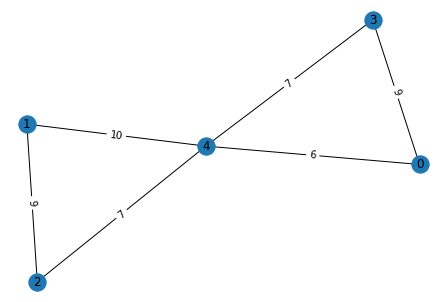

In [4]:
# ---- Define graph and MaxCut ----
graph = generate_butterfly_graph(with_weights=True)
opt_max_cut = -35
max_cut = Maxcut(graph, opt_max_cut)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

# Display MaxCut-Landscape for p = 1

In [11]:
from landscape_helper import *

In [41]:
landscape = load_landscape_data('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/landscape/simulator/landscape_simulator_butterfly_weights_results.npy')

TypeError: load_landscape_data() missing 1 required positional argument: 'max_cut'

In [ ]:
min_gamma, min_beta, min_exp = describe_landscape(landscape)

In [12]:
from plot_helper import *

In [ ]:
# Plot landscape in 3D 
plot_landscape_3d(landscape)

In [ ]:
# Plot Heatmap 
heatmap = plot_heatmap(landscape)
heatmap = display_minimum(heatmap, min_gamma, min_beta, min_exp)

### Find init values with TQA

In [13]:
from tqa import calculate_tqa

In [49]:
p = 1

In [50]:
tqa_initial_points = calculate_tqa(graph, p)

TQA: Gamma: [1.26507538], Beta: [1.26507538] (p=1)


#### Run QAOA with init_points, different optimizers and plot results 

In [14]:
from qaoa_helper import *

In [ ]:
qnSpsa = QNSPSA(calculate_fidelity(create_qaoa(), max_cut_qubo), maxiter=50)
optimizers = [
    ('COBYLA',COBYLA(maxiter=50)),
    ('SPSA', SPSA(maxiter=50)),
    ('QNSPSA', qnSpsa),
]

In [ ]:
for optimizer_tuple in optimizers:
    optimizer_name, optimizer = optimizer_tuple
    # create qaoa 
    qaoa = create_qaoa(optimizer = optimizer,
            reps=p,
            initial_point=tqa_initial_points,
            with_callback=True
           )
    # run qaoa 
    result, optimal_parameters, optimizer_history = run_qaoa_with_callback(qaoa, max_cut_qubo)
    
    # analyse results 
    print(f"{optimizer_name} Optimizer")
    mean, distribution = max_cut.analyse(result, print_output=True)
    max_cut.plot_histogram(distribution, mean)
    optimizer_history[2][-1] = mean
    print()
    
    # Display Optimizer Results
    counts, energy_values, maxcut_values, optimizer_gammas, optimizer_betas = optimizer_history
    display_optimizer_path(heatmap, optimizer_gammas, optimizer_betas, maxcut_values, optimizer_name)
    
    # Plot Optimizer History MaxCut Evaluation # Values from landscape -> real values may deviate 
    plot_optimizer_maxcut_history(counts, maxcut_values, optimizer_name)
    
    # Plot Optimizer History Energy Evaluation -> not MaxCutMean! 
    plot_optimizer_energy_history(counts, energy_values, optimizer_name)
    

# Comparision

## Parameters

In [15]:
eval_num = 100
max_p = 10
all_results = {}

## QAOA

In [16]:
from qaoa_helper import *

In [ ]:
qaoa_p_means = []
qaoa_p_ratios = []
qaoa_p_approx_ratios = []

for p in range(1,max_p+1):
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p)
    qaoa_p_means.append(m)
    qaoa_p_ratios.append(r)
    qaoa_p_approx_ratios.append(ar)

all_results["QAOA"] = [qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios]

In [ ]:
display_boxplots_results(qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios)

## QAOA with TQA

In [17]:
from qaoa_helper import *

In [ ]:
tqa_p_means = []
tqa_p_ratios = []
tqa_p_approx_ratios = []
tqa_init_points = []

for p in range(1,max_p+1):
    tqa_initial_points = calculate_tqa(graph, p)
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p, init_points=tqa_initial_points)
    tqa_p_means.append(m)
    tqa_p_ratios.append(r)
    tqa_p_approx_ratios.append(ar)
    tqa_init_points.append(tqa_initial_points)
    
all_results["TQA QAOA"] = [tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, tqa_init_points]

In [ ]:
display_boxplots_results(tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, prefix='TQA ')

## WarmStart QAOA

In [18]:
from warmstart_helper import *

In [ ]:
ws_p_means = []
ws_p_ratios = []
ws_p_approx_ratios = []
ws_opt_epsilons = []

for p in range(1,max_p+1):
    opt_epsilon = 0.25 #optimize_epsilon(max_cut, reps=p)
    m, r, ar = start_ws_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p, epsilon=0.25)
    ws_p_means.append(m)
    ws_p_ratios.append(r)
    ws_p_approx_ratios.append(ar)
    ws_opt_epsilons.append(opt_epsilon)
    
all_results["WarmStart QAOA"] = [ws_p_means, ws_p_ratios, ws_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_p_means, ws_p_ratios, ws_p_approx_ratios, prefix='WarmStart ')

### Recursive QAOA

In [19]:
from recursive_qaoa_helper import *

In [ ]:
recursive_p_means = []
recursive_p_ratios = []
recursive_p_approx_ratios = []

for p in range(1,max_p+1):
    m, r, ar = start_recursive_evaluation(max_cut, eval_num=eval_num, reps=p)
    recursive_p_means.append(m)
    recursive_p_ratios.append(r)
    recursive_p_approx_ratios.append(ar)

all_results["Recursive QAOA"] = [recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios]

In [ ]:
display_boxplots_results(recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios, prefix='Recursive ')

### Recursive WarmStart QAOA

In [5]:
from recursive_ws_helper import *

In [ ]:
ws_recursive_p_means = []
ws_recursive_p_ratios = []
ws_recursive_p_approx_ratios = []

for p in range(1,max_p+1):
    opt_epsilon = ws_opt_epsilons[p-1]
    m, r, ar = start_recursive_ws_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p, epsilon=opt_epsilon)
    ws_recursive_p_means.append(m)
    ws_recursive_p_ratios.append(r)
    ws_recursive_p_approx_ratios.append(ar)
    
all_results["Recursive WarmStrart QAOA"] = [ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, prefix='Recursive WarmStart ')

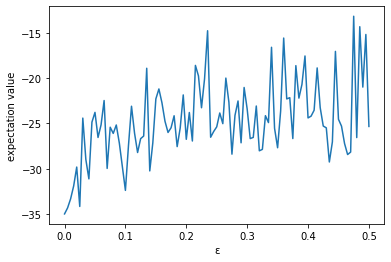

ɛ=0.0
mean: -24.70496287128712
mean: -25.170499999999993


In [99]:
# GoemansWilliamsonOptimizer

means = []
eps = []
#for e in range(100,-1, -1):
for e in range(100,-1, -1):
    epsi = e*0.005
    # only add if opt_maxt_cut is found  
    qaoa = create_qaoa(reps=2)
    mean, found = run_epsilon_evaluation_ws_qaoa(max_cut, qaoa, epsilon=epsi, print_output=False)
    if found: 
        means.append(mean)
        eps.append(epsi)

plt.plot(eps, means)
plt.xlabel('ɛ')
plt.ylabel('expectation value')
plt.show()
opt_eps = eps[ np.argmin(means) ]
print(f"ɛ={opt_eps}")
print(f"mean: {np.mean(means)}")
print(f"median: {np.median(means)}")

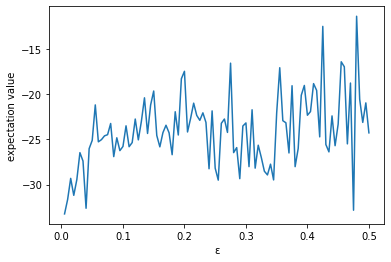

ɛ=0.005
mean: -24.0720275
median: -24.277750000000005


In [101]:

#CobylaOptimizer
means = []
eps = []
#for e in range(100,-1, -1):
for e in range(100,-1, -1):
    epsi = e*0.005
    # only add if opt_maxt_cut is found  
    qaoa = create_qaoa(reps=2)
    mean, found = run_epsilon_evaluation_ws_qaoa(max_cut, qaoa, epsilon=epsi, print_output=False)
    if found: 
        means.append(mean)
        eps.append(epsi)

plt.plot(eps, means)
plt.xlabel('ɛ')
plt.ylabel('expectation value')
plt.show()
opt_eps = eps[ np.argmin(means) ]
print(f"ɛ={opt_eps}")
print(f"mean: {np.mean(means)}")
print(f"median: {np.median(means)}")

0.5
0.495
0.49
0.485
0.485
0.485
0.47500000000000003
0.47000000000000003
0.465
0.46
0.455
0.45
0.45
0.45
0.435
0.43
0.43
0.425
0.42
0.41500000000000004
0.41500000000000004
0.41000000000000003
0.41000000000000003
0.4
0.395
0.395
0.39
0.385
0.37
0.365
0.35000000000000003
0.35000000000000003
0.34500000000000003
0.34
0.33
0.315
0.28500000000000003
0.28
0.27
0.245
0.23500000000000001
0.225
0.22
0.215
0.19
0.17500000000000002
0.16
0.145
0.14
0.135
0.115
0.105


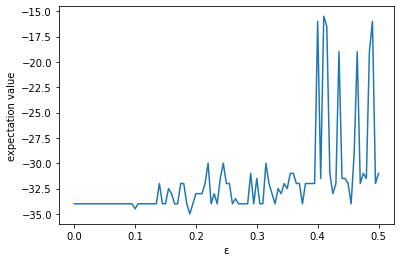

ɛ=0.19


In [104]:
# Cobyla 

c_means = []
c_eps = []
#for e in range(100,-1, -1):
for e in range(100,-1, -1):
    epsi = e*0.005
    # only add if opt_maxt_cut is found  
    temp_means = []
    for n in range(0,10):
        qaoa = create_qaoa(reps=1)
        try:
            mean, r,ar = run_evaluation_recursive_ws_qaoa(max_cut, qaoa, epsilon=epsi, print_output=False)
            temp_means.append(mean)
            
        except: 
            try:
                mean, r,ar = run_evaluation_recursive_ws_qaoa(max_cut, qaoa, epsilon=epsi, print_output=False)
                temp_means.append(mean)
                
            except: 
                print(f"{epsi}")
    c_means.append(np.median(temp_means))
    c_eps.append(epsi)


plt.plot(c_eps, c_means)
plt.xlabel('ɛ')
plt.ylabel('expectation value')
plt.show()
opt_eps = c_eps[ np.argmin(c_means) ]
print(f"ɛ={opt_eps}")

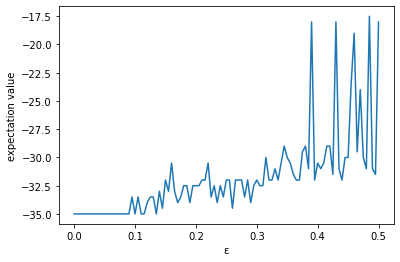

ɛ=0.135


In [102]:
# GoemansWilliamsonOptimizer

means = []
eps = []
#for e in range(100,-1, -1):
for e in range(100,-1, -1):
    epsi = e*0.005
    # only add if opt_maxt_cut is found  
    temp_means = []
    for n in range(0,20):
        qaoa = create_qaoa(reps=1)
        try:
            mean, r,ar = run_evaluation_recursive_ws_qaoa(max_cut, qaoa, epsilon=epsi, print_output=False)
            temp_means.append(mean)
            
        except: 
            try:
                mean, r,ar = run_evaluation_recursive_ws_qaoa(max_cut, qaoa, epsilon=epsi, print_output=False)
                temp_means.append(mean)
                
            except: 
                print(f"{epsi}")
    means.append(np.median(temp_means))
    eps.append(epsi)


plt.plot(eps, means)
plt.xlabel('ɛ')
plt.ylabel('expectation value')
plt.show()
opt_eps = eps[ np.argmin(means) ]
print(f"ɛ={opt_eps}")

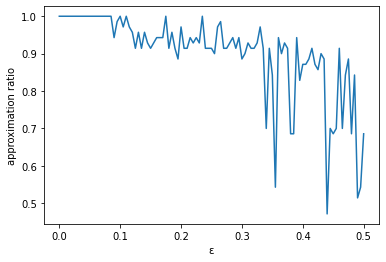

ɛ=0.44


In [6]:
# GoemansWilliamsonOptimizer

means = []
eps = []
#for e in range(100,-1, -1):
for e in range(100,-1, -1):
    epsi = e*0.005
    # only add if opt_maxt_cut is found  
    temp_means = []
    for n in range(0,20):
        qaoa = create_qaoa(reps=1)
        try:
            mean, r,ar = run_evaluation_recursive_ws_qaoa(max_cut, qaoa, epsilon=epsi, print_output=False)
            temp_means.append(ar)
            
        except: 
            try:
                mean, r,ar = run_evaluation_recursive_ws_qaoa(max_cut, qaoa, epsilon=epsi, print_output=False)
                temp_means.append(ar)
                
            except: 
                print(f"{epsi}")
    means.append(np.median(temp_means))
    eps.append(epsi)


plt.plot(eps, means)
plt.xlabel('ɛ')
plt.ylabel('approximation ratio')
plt.show()
opt_eps = eps[ np.argmin(means) ]
print(f"ɛ={opt_eps}")

In [90]:
qaoa = create_qaoa(reps=2, initial_point= [5.,5, 1,1.0])
ws = WarmStartQAOAOptimizer(pre_solver=GoemansWilliamsonOptimizer(5), relax_for_pre_solver=False, qaoa=qaoa, epsilon=0.0)
result = ws.solve(max_cut_qubo)
print(qaoa.optimal_params)
print(qaoa.setting)

dict_items([(ParameterVectorElement(β[0]), ParameterVectorElement(β[0])), (ParameterVectorElement(β[1]), ParameterVectorElement(β[1])), (ParameterVectorElement(γ[0]), ParameterVectorElement(γ[0])), (ParameterVectorElement(γ[1]), ParameterVectorElement(γ[1]))])
β[0]
Don't use mitiq
[5. 5. 1. 1.]
Algorithm: Mitiq_QAOA
-- reps: 2
-- mixer:      ┌───────┐ ┌───────────────┐┌───────┐
q_0: ┤ Ry(0) ├─┤ Rz(-2.0*beta) ├┤ Ry(0) ├
     ├───────┤ ├───────────────┤├───────┤
q_1: ┤ Ry(0) ├─┤ Rz(-2.0*beta) ├┤ Ry(0) ├
     ├───────┤ ├───────────────┤├───────┤
q_2: ┤ Ry(0) ├─┤ Rz(-2.0*beta) ├┤ Ry(0) ├
     ├───────┤ ├───────────────┤├───────┤
q_3: ┤ Ry(0) ├─┤ Rz(-2.0*beta) ├┤ Ry(0) ├
     ├───────┴┐├───────────────┤├───────┤
q_4: ┤ Ry(-π) ├┤ Rz(-2.0*beta) ├┤ Ry(π) ├
     └────────┘└───────────────┘└───────┘
-- initial_state:      ┌───────┐
q_0: ┤ Ry(0) ├
     ├───────┤
q_1: ┤ Ry(0) ├
     ├───────┤
q_2: ┤ Ry(0) ├
     ├───────┤
q_3: ┤ Ry(0) ├
     ├───────┤
q_4: ┤ Ry(π) ├
     └───────┘
-- quantum_insta

AttributeError: 'QuadraticProgram' object has no attribute 'num_qubits'

In [23]:
means

[-21.0,
 -23.3,
 -24.9,
 -22.4,
 -24.1,
 -23.0,
 -20.2,
 -12.3,
 -22.5,
 -21.6,
 -24.4,
 -20.5,
 -24.3,
 -27.7,
 -26.7,
 -20.7,
 -29.5,
 -27.6,
 -28.4,
 -24.5,
 -15.4,
 -19.4,
 -24.2,
 -29.8,
 -29.9,
 -27.3,
 -27.5,
 -26.0,
 -21.8,
 -29.3,
 -27.6,
 -20.7,
 -29.0,
 -29.4,
 -26.1,
 -28.0,
 -28.3,
 -23.7,
 -29.5,
 -28.9,
 -33.6,
 -32.7,
 -28.1,
 -26.3,
 -33.5,
 -30.3,
 -28.0,
 -30.7,
 -31.8,
 -26.0,
 -30.0,
 -31.5,
 -26.6,
 -32.1,
 -31.7,
 -30.6,
 -33.6,
 -29.1,
 -29.8,
 -34.2,
 -29.5,
 -32.2,
 -28.0,
 -28.0,
 -31.4,
 -32.5,
 -30.9,
 -28.7,
 -33.8,
 -33.0,
 -29.3,
 -29.0,
 -29.8,
 -33.4,
 -30.9,
 -29.3,
 -32.7,
 -30.8,
 -32.1,
 -31.9,
 -28.4,
 -33.9,
 -32.2,
 -32.2,
 -32.8,
 -31.7,
 -32.8,
 -35.0,
 -34.1,
 -35.0,
 -35.0,
 -34.7,
 -35.0,
 -34.7,
 -34.7,
 -34.4,
 -35.0,
 -34.4,
 -34.4,
 -34.7,
 -35.0]

## Results

In [ ]:
# Save results 
with open(f'comparison_simulator_{graph.name}_no_epsilon_results.npy', 'wb') as f:
    np.save(f, all_results)

In [21]:
from results_helper import *

In [82]:
means_df, ratio_df, approx_ratios_df = generate_dataframes(all_results)

### Metric Mean

In [83]:
means_df

,QAOA,TQA QAOA,WarmStart QAOA,Recursive QAOA,Recursive WarmStrart QAOA
p,,,,,
1,-30.51,-28.85,-29.34,-34.57,-34.68
2,-30.65,-29.14,-29.40,-34.55,-34.61
3,-30.86,-31.69,-29.73,-34.62,-34.64
4,-30.95,-31.95,-29.52,-34.71,-34.74
5,-30.99,-30.73,-29.51,-34.66,-34.69
6,-30.50,-30.54,-29.14,-34.82,-34.75
7,-30.69,-31.25,-28.98,-34.74,-34.63
8,-30.20,-29.67,-28.85,-34.73,-34.62
9,-30.04,-31.84,-28.49,-34.72,-34.56


### Metric Ratio 

In [84]:
ratio_df

,QAOA,TQA QAOA,WarmStart QAOA,Recursive QAOA,Recursive WarmStrart QAOA
p,,,,,
1,0.87,0.82,0.84,0.0,0.0
2,0.87,0.83,0.84,0.0,0.0
3,0.88,0.91,0.85,0.0,0.0
4,0.88,0.91,0.84,0.0,0.0
5,0.88,0.88,0.84,0.0,0.0
6,0.87,0.87,0.83,0.0,0.0
7,0.88,0.89,0.83,0.0,0.0
8,0.86,0.85,0.82,0.0,0.0
9,0.86,0.91,0.81,0.0,0.0


### Metric Approximation Ratio

In [85]:
approx_ratios_df

,QAOA,TQA QAOA,WarmStart QAOA,Recursive QAOA,Recursive WarmStrart QAOA
p,,,,,
1,0.87,0.82,0.84,0.99,0.99
2,0.88,0.83,0.84,0.99,0.99
3,0.88,0.91,0.85,0.99,0.99
4,0.88,0.91,0.84,0.99,0.99
5,0.89,0.88,0.84,0.99,0.99
6,0.87,0.87,0.83,0.99,0.99
7,0.88,0.89,0.83,0.99,0.99
8,0.86,0.85,0.82,0.99,0.99
9,0.86,0.91,0.81,0.99,0.99
